# Bitcoin and Ethereum price prediction with RNN LSTM


Importing necessary libraries

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import gc
import keras
from keras.models import Sequential
from keras.layers import Activation,Dense,LSTM,Dropout
from functools import reduce

%matplotlib inline

Setting up hyper parameters and global variables for our model:

In [136]:
neurons = 512                 # number of hidden units in the LSTM layer
activation_function = 'tanh'  # activation function for LSTM and Dense layer
loss = 'mse'                  # loss function for calculating the gradient, in this case Mean Squared Error
optimizer= 'adam'             # optimizer for appljying gradient decent
dropout = 0.25                # dropout ratio used after each LSTM layer to avoid overfitting
batch_size = 128              
epochs = 53                  
window_len = 7               # is an intiger to be used as the look back window for creating a single input sample.
training_size = 0.8           # porportion of data to be used for training
merge_date = '2016-01-01'     # the earliest date which we have data for both ETH and BTC or any other provided coin

Here we will define functions for preprocessing our data as well as the build_model function:

In [339]:
def get_market_data(market, tag=True):
  """
  market: the full name of the cryptocurrency as spelled on coinmarketcap.com. eg.: 'bitcoin'
  tag: eg.: 'btc', if provided it will add a tag to the name of every column.
  returns: panda DataFrame
  This function will use the coinmarketcap.com url for provided coin/token page. 
  Converts the date format to be readable. 
  Makes sure that the data is consistant by converting non_numeric values to a number very close to 0.
  And finally tags each columns if provided.
  """
  market_data = pd.read_html("https://coinmarketcap.com/currencies/" + market + 
                             "/historical-data/?start=20181127&end="+time.strftime("%Y%m%d"), flavor='html5lib')[0]
  market_data = market_data.assign(Date=pd.to_datetime(market_data['Date']))  
  market_data['Volume'] = (pd.to_numeric(market_data['Volume'], errors='coerce').fillna(0))
  if tag:
    market_data.columns = [market_data.columns[0]] + [tag + '_' + i for i in market_data.columns[1:]]
  return market_data

def merge_data(a, b,from_date=merge_date):
  """
  a: first DataFrame
  b: second DataFrame
  from_date: includes the data from the provided date and drops the any data before that date.
  returns merged data as Pandas DataFrame
  """
  merged_data = pd.merge(a, b, on=['Date'])
  merged_data = merged_data[merged_data['Date'] >= from_date]
  merged_data
  return merged_data

def add_volatility(data, coins=['BAT', 'ETH']):
  """
  data: input data, pandas DataFrame
  coins: default is for 'btc and 'eth'. It could be changed as needed
  This function calculates the volatility and close_off_high of each given coin in 24 hours, 
  and adds the result as new columns to the DataFrame.
  Return: DataFrame with added columns
  """
  for coin in coins:
    # calculate the daily change
    kwargs = {coin + '_change': lambda x: (x[coin + '_Close'] - x[coin + '_Open']) / x[coin + '_Open'],
             coin + '_close_off_high': lambda x: 2*(x[coin + '_High'] - x[coin + '_Close']) / (x[coin + '_High'] - x[coin + '_Low']) - 1,
             coin + '_volatility': lambda x: (x[coin + '_High'] - x[coin + '_Low']) / (x[coin + '_Open'])}
    data = data.assign(**kwargs)
  return data


def create_model_data(data):
  """
  data: pandas DataFrame
  This function drops unnecessary columns and combines together the growth and pricing data and the order of DataFrame based on decending dates.
  Return: pandas DataFrame
  """
  data = data[['Date']+['Publishers'] + ['twitter']+ ['youtube'] + [coin+metric for coin in ['BAT_', 'ETH_'] for metric in ['Close**','Volume']]]
  data = data.sort_values(by='Date')
  return data


def split_data(data, training_size=0.8):
  """
  data: Pandas Dataframe
  training_size: proportion of the data to be used for training
  This function splits the data into training_set and test_set based on the given training_size
  Return: train_set and test_set as pandas DataFrame
  """
  return data[:int(training_size*len(data))], data[int(training_size*len(data)):]


def create_inputs(data, coins=['BAT', 'ETH'], window_len=window_len):
  """
  data: pandas DataFrame, this could be either training_set or test_set
  coins: coin datas which will be used as the input. Default is 'btc', 'eth'
  window_len: is an intiger to be used as the look back window for creating a single input sample.
  This function will create input array X from the given dataset and will normalize 'Close' and 'Volume' between 0 and 1
  Return: X, the input for our model as a python list which later needs to be converted to numpy array.
  """
  norm_cols = [coin + metric for coin in coins for metric in ['_Close**', '_Volume']]
  inputs = []
  for i in range(len(data) - window_len):
    temp_set = data[i:(i + window_len)].copy()
    inputs.append(temp_set)
    for col in norm_cols:
      inputs[i].loc[:, col] = inputs[i].loc[:, col] / inputs[i].loc[:, col].iloc[0] - 1  
  return inputs


def create_outputs(data, coin, window_len=window_len):
  """
  data: pandas DataFrame, this could be either training_set or test_set
  coin: the target coin in which we need to create the output labels for
  window_len: is an intiger to be used as the look back window for creating a single input sample.
  This function will create the labels array for our training and validation and normalize it between 0 and 1
  Return: Normalized numpy array for 'Close' prices of the given coin
  """
  return (data[coin + '_Close**'][window_len:].values / data[coin + '_Close**'][:-window_len].values) - 1


def to_array(data):
  """
  data: DataFrame
  This function will convert list of inputs to a numpy array
  Return: numpy array
  """
  x = [np.array(data[i]) for i in range (len(data))]
  return np.array(x)


def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
  """
  inputs: input data as numpy array
  output_size: number of predictions per input sample
  neurons: number of neurons/ units in the LSTM layer
  active_func: Activation function to be used in LSTM layers and Dense layer
  dropout: dropout ration, default is 0.25
  loss: loss function for calculating the gradient
  optimizer: type of optimizer to backpropagate the gradient
  This function will build 3 layered RNN model with LSTM cells with dripouts after each LSTM layer 
  and finally a dense layer to produce the output using keras' sequential model.
  Return: Keras sequential model and model summary
  """
  model = Sequential()
  model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.add(Activation(activ_func))
  model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
  model.summary()
  return model

Below are the functions for plotting market data and the results after the training:

In [340]:
def show_plot(data, tag):
  fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
  ax1.set_ylabel('Closing Price ($)',fontsize=12)
  ax2.set_ylabel('Volume ($ bn)',fontsize=12)
  ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
  ax2.set_yticklabels(range(10))
  ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax1.set_xticklabels('')
  ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
  ax1.plot(data['Date'].astype(datetime.datetime),data[tag +'_Open*'])
  ax2.bar(data['Date'].astype(datetime.datetime).values, data[tag +'_Volume'].values)
  fig.tight_layout()
  plt.show()
  

def date_labels():
  last_date = market_data.iloc[0, 0]
  date_list = [last_date - datetime.timedelta(days=x) for x in range(len(X_test))]
  return[date.strftime('%m/%d/%Y') for date in date_list][::-1]


def plot_results(history, model, Y_target, coin):
  plt.figure(figsize=(25, 20))
  plt.subplot(311)
  plt.plot(history.epoch, history.history['loss'], )
  plt.plot(history.epoch, history.history['val_loss'])
  plt.xlabel('Number of Epochs')
  plt.ylabel('Loss')
  plt.title(coin + ' Model Loss')
  plt.legend(['Training', 'Test'])

  plt.subplot(312)
  plt.plot(Y_target)
  plt.plot(model.predict(X_train))
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title(coin + ' Single Point Price Prediction on Training Set')
  plt.legend(['Actual','Predicted'])

  ax1 = plt.subplot(313)
  plt.plot(test_set[coin + '_Close**'][window_len:].values.tolist())
  plt.plot(((np.transpose(model.predict(X_test)) + 1) * test_set[coin + '_Close**'].values[:-window_len])[0])
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title(coin + ' Single Point Price Prediction on Test Set')
  plt.legend(['Actual','Predicted'])
  
  date_list = date_labels()
  ax1.set_xticks([x for x in range(len(date_list))])
  for label in ax1.set_xticklabels([date for date in date_list], rotation='vertical')[::2]:
    label.set_visible(False)

  plt.show()

In [341]:
bat_data = get_market_data("basic-attention-token", tag='BAT')
eth_data = get_market_data("ethereum", tag='ETH')

In [342]:
bat_data.head()

,Date,BAT_Open*,BAT_High,BAT_Low,BAT_Close**,BAT_Volume,BAT_Market Cap
0,2019-05-30,0.361618,0.380639,0.324967,0.338844,64090459,428251715
1,2019-05-29,0.369704,0.369704,0.349140,0.361843,48199125,457319136
2,2019-05-28,0.377856,0.378794,0.361597,0.369532,53640218,467036870
3,2019-05-27,0.354014,0.387582,0.353339,0.377659,67307227,477308367
4,2019-05-26,0.348438,0.356870,0.341822,0.353908,50611929,447290093


In [343]:
eth_data.head()

,Date,ETH_Open*,ETH_High,ETH_Low,ETH_Close**,ETH_Volume,ETH_Market Cap
0,2019-05-30,269.55,287.20,247.35,255.86,13604268584,27194892741
1,2019-05-29,271.78,273.76,263.09,269.46,9819132174,28636457373
2,2019-05-28,272.59,274.32,267.51,271.77,10362846898,28878512607
3,2019-05-27,267.14,278.51,265.44,272.86,12074664736,28991071396
4,2019-05-26,251.72,269.17,247.25,267.07,9664267731,28371943145


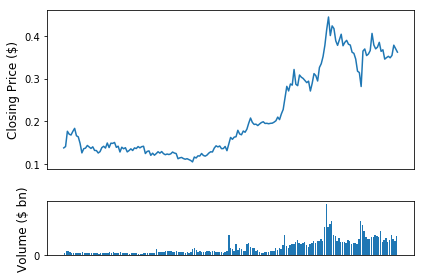

In [344]:
show_plot(bat_data, tag='BAT')


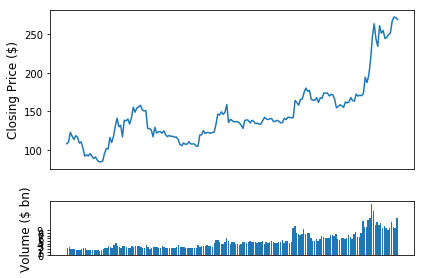

In [345]:
show_plot(eth_data, tag='ETH')


Merging the BTC and ETH data and splitting them to training and test sets:

In [325]:
#Publisher data generated using beutiful soup starting from earliest date for publisher count 11/27/17

In [366]:
publishers = [9861, 9822, 9580, 9589, 9591, 9371, 9376, 9260, 9207, 9087, 8962, 8776, 8532, 8441, 8229, 7976, 7812, 7595, 7329, 7078, 6716, 6386, 6253, 6131, 6043, 5894, 5820, 5766, 5695, 5607, 5171, 4768, 4306, 4219, 4106, 4075, 3980, 3900, 3821, 3788, 3724, 3590, 3596, 3412, 3416, 3247, 3220, 3185, 3123, 3085, 3004, 2933, 2910, 2891, 2862, 2855, 2838, 2812, 2798, 2776, 2748, 2718, 2693, 2653, 2596, 2524, 2467, 2408, 2340, 2320, 2294, 2265, 2258, 2230, 2188, 2175, 2162, 2122, 2095, 2050, 1959, 1830, 1824, 1809, 1801, 1784, 1767, 1751, 1688, 1549, 1546, 1543, 1537, 1529, 1523, 1519, 1506, 1494, 1482, 1476, 1473, 1467, 1464, 1459, 1446, 1438, 1433, 1428, 1419, 1410, 1394, 1386, 1379, 1051, 1036, 1012, 1002, 996, 987, 976, 976, 255, 132, 162, 235, 255, 206, 192, 192, 153, 102, 255, 255, 159, 255, 132, 162, 235, 255, 206, 192, 192, 153, 102, 255, 255, 159]
publishers_df = pd.DataFrame(publishers,columns=["Publishers"])
publishers_df.head() #twich


,Publishers
0,9861
1,9822
2,9580
3,9589
4,9591


In [367]:
publishers_df.shape

(147, 1)

In [358]:
twitter = [98749, 93587, 90845, 88114, 83448, 80572, 77152, 73397, 70380, 66608, 63593, 62731, 61491, 60495, 58802, 57827, 57208, 56171, 55223, 52872, 50976, 48422, 47133, 45101, 44706, 42941, 41335, 40387, 39898, 38986, 37873, 37773, 36005, 35005, 33490, 33206, 32426, 31598, 30987, 29793, 30065, 29832, 29576, 29340, 29175, 29039, 28847, 28649, 28425, 28184, 27852, 27580, 27070, 26355, 25810, 25324, 24857, 24452, 24245, 24040, 23886, 23829, 23715, 23536, 23361, 23175, 22988, 22750, 22493, 21546, 20144, 20138, 19967, 19840, 19676, 19541, 19360, 18916, 18832, 18757, 18671, 18578, 18472, 18363, 18103, 17887, 17714, 17529, 17398, 17253, 17133, 17046, 16916, 16619, 16400, 16271, 16105, 15921, 15541, 15305, 15247, 15203, 13357, 13306, 13237, 13162, 13128, 13067, 12916, 1291698749, 93587, 90845, 88114, 83448, 80572, 77152, 73397, 70380, 66608, 63593, 62731, 61491, 60495, 58802, 57827, 57208, 56171, 55223, 52872, 50976, 48422, 47133, 45101, 44706, 42941, 41335, 40387, 39898, 38986, 37873, 37773, 36005, 35005, 33490, 33206, 32426, 31598, 30987, 29793, 30065, 29832, 29576, 29340, 29175, 29039, 28847, 28649, 28425, 28184, 27852, 27580, 27070, 26355, 25810, 25324, 24857, 24452, 24245, 24040, 23886, 23829, 23715, 23536, 23361, 23175, 22988, 22750, 22493, 21546, 20144, 20138, 19967, 19840, 19676, 19541, 19360, 18916, 18832, 18757, 18671, 18578, 18472, 18363, 18103, 17887, 17714, 17529, 17398, 17253, 17133, 17046, 16916, 16619, 16400, 16271, 16105, 15921, 15541, 15305, 15247, 15203, 13357, 13306, 13237, 13162, 13128, 13067, 12916, 12916]
twitter_df = pd.DataFrame(twitter,columns=["twitter"])
twitter_df.head()

,twitter
0,98749
1,93587
2,90845
3,88114
4,83448


In [360]:
youtube = [117251,
 116731,
 113960,
 114056,
 114000,
 110507,
 110556,
 108530,
 107396,
 105001,
 102569, 98749, 93587, 90845, 88114, 83448, 80572, 77152, 73397, 70380, 66608, 63593, 62731, 61491, 60495, 58802, 57827, 57208, 56171, 55223, 52872, 50976, 48422, 47133, 45101, 44706, 42941, 41335, 40387, 39898, 38986, 37873, 37773, 36005, 35005, 33490, 33206, 32426, 31598, 30987, 29793, 30065, 29832, 29576, 29340, 29175, 29039, 28847, 28649, 28425, 28184, 27852, 27580, 27070, 26355, 25810, 25324, 24857, 24452, 24245, 24040, 23886, 23829, 23715, 23536, 23361, 23175, 22988, 22750, 22493, 21546, 20144, 20138, 19967, 19840, 19676, 19541, 19360, 18916, 18832, 18757, 18671, 18578, 18472, 18363, 18103, 17887, 17714, 17529, 17398, 17253, 17133, 17046, 16916, 16619, 16400, 16271, 16105, 15921, 15541, 15305, 15247, 15203, 13357, 13306, 13237, 13162, 13128, 13067, 12916, 1291698749, 93587, 90845, 88114, 83448, 80572, 77152, 73397, 70380, 66608, 63593, 62731, 61491, 60495, 58802, 57827, 57208, 56171, 55223, 52872, 50976, 48422, 47133, 45101, 44706, 42941, 41335, 40387, 39898, 38986, 37873, 37773, 36005, 35005, 33490, 33206, 32426, 31598, 30987, 29793, 30065, 29832, 29576, 29340, 29175, 29039, 28847, 28649, 28425, 28184, 27852, 27580, 27070, 26355, 25810, 25324, 24857, 24452, 24245, 24040, 23886, 23829, 23715, 23536, 23361, 23175, 22988, 22750, 22493, 21546, 20144, 20138, 19967, 19840, 19676, 19541, 19360, 18916, 18832, 18757, 18671, 18578, 18472, 18363, 18103, 17887, 17714, 17529, 17398, 17253, 17133, 17046, 16916, 16619, 16400, 16271, 16105, 15921, 15541, 15305, 15247, 15203, 13357, 13306, 13237, 13162, 13128, 13067, 12916, 12916]
youtube_df = pd.DataFrame(youtube,columns=["youtube"])
youtube_df.head()

,youtube
0,117251
1,116731
2,113960
3,114056
4,114000


In [361]:
youtube_df.shape

(230, 1)

In [330]:
#bat_data =  pd.concat([bat_data, publishers_df,twitter_df,youtube_df], axis=1, sort=False)

In [331]:
market_data = merge_data(bat_data, eth_data)
market_data = pd.concat([market_data, publishers_df,twitter_df,youtube_df], axis=1, sort=False)
model_data = create_model_data(market_data)
train_set, test_set = split_data(model_data)

Pre-processing data and producing inputs and target outputs:

In [332]:
market_data.columns

Index(['Date', 'BAT_Open*', 'BAT_High', 'BAT_Low', 'BAT_Close**', 'BAT_Volume',
       'BAT_Market Cap', 'ETH_Open*', 'ETH_High', 'ETH_Low', 'ETH_Close**',
       'ETH_Volume', 'ETH_Market Cap', 'Publishers', 'twitter', 'youtube'],
      dtype='object')

In [333]:
model_data.columns

Index(['Date', 'Publishers', 'twitter', 'youtube', 'BAT_Close**', 'BAT_Volume',
       'ETH_Close**', 'ETH_Volume'],
      dtype='object')

/Users/Deepesh.Chaudhari/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


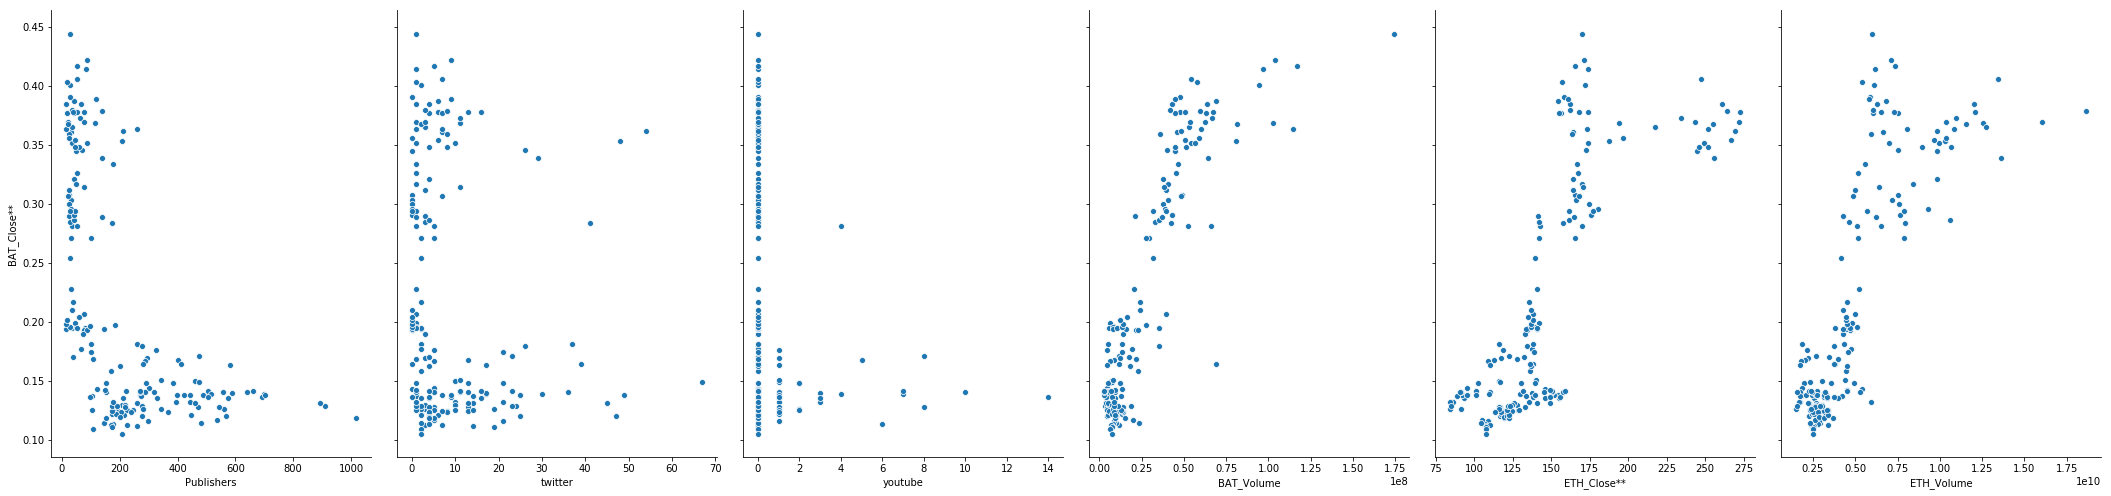

In [351]:
# visualize the relationship between the features and the response using scatterplots
sns.pairplot(model_data, x_vars=['Publishers', 'twitter', 'youtube',  'BAT_Volume',
       'ETH_Close**', 'ETH_Volume'], y_vars='BAT_Close**', size=7, aspect=0.7)

/Users/Deepesh.Chaudhari/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/Users/Deepesh.Chaudhari/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


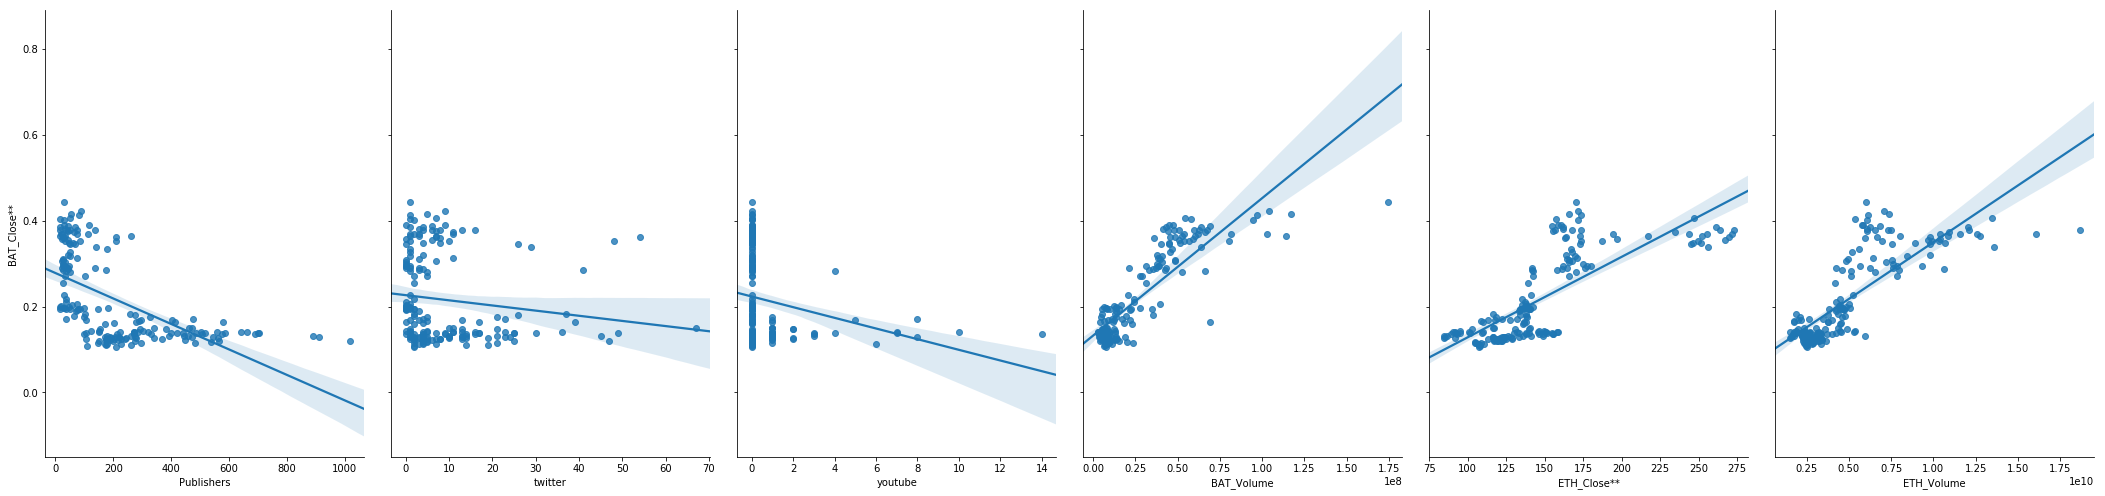

In [353]:
sns.pairplot(model_data, x_vars=['Publishers', 'twitter', 'youtube',  'BAT_Volume',
       'ETH_Close**', 'ETH_Volume'], y_vars='BAT_Close**', size=7, aspect=0.7, kind='reg')

## Given the current relationship I decided to use growth data extracted from Coinmarketcap for important predictors

In [335]:
train_set = train_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

X_train = create_inputs(train_set)
Y_train_bat = create_outputs(train_set, coin='BAT')
X_test = create_inputs(test_set)
Y_test_bat = create_outputs(test_set, coin='BAT')

Y_train_eth = create_outputs(train_set, coin='ETH')
Y_test_eth = create_outputs(test_set, coin='ETH')

X_train, X_test = to_array(X_train), to_array(X_test)

print (np.shape(X_train), np.shape(X_test), np.shape(Y_train_btc), np.shape(Y_test_btc))
print (np.shape(X_train), np.shape(X_test), np.shape(Y_train_eth), np.shape(Y_test_eth))

(141, 7, 7) (30, 7, 7) (576,) (139,)
(141, 7, 7) (30, 7, 7) (141,) (30,)


Initializing the model and training it for predicting BTC price for next day:

In [336]:
# clean up the memory
gc.collect()

# random seed for reproducibility
np.random.seed(202)

# initialise model architecture
bat_model = build_model(X_train, output_size=1, neurons=neurons)

# train model on data
bat_history = bat_model.fit(X_train, Y_train_bat, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test_bat), shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 7, 512)            1064960   
_________________________________________________________________
dropout_34 (Dropout)         (None, 7, 512)            0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 7, 512)            2099200   
_________________________________________________________________
dropout_35 (Dropout)         (None, 7, 512)            0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dropout_36 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 513       
__________

Plot the results:

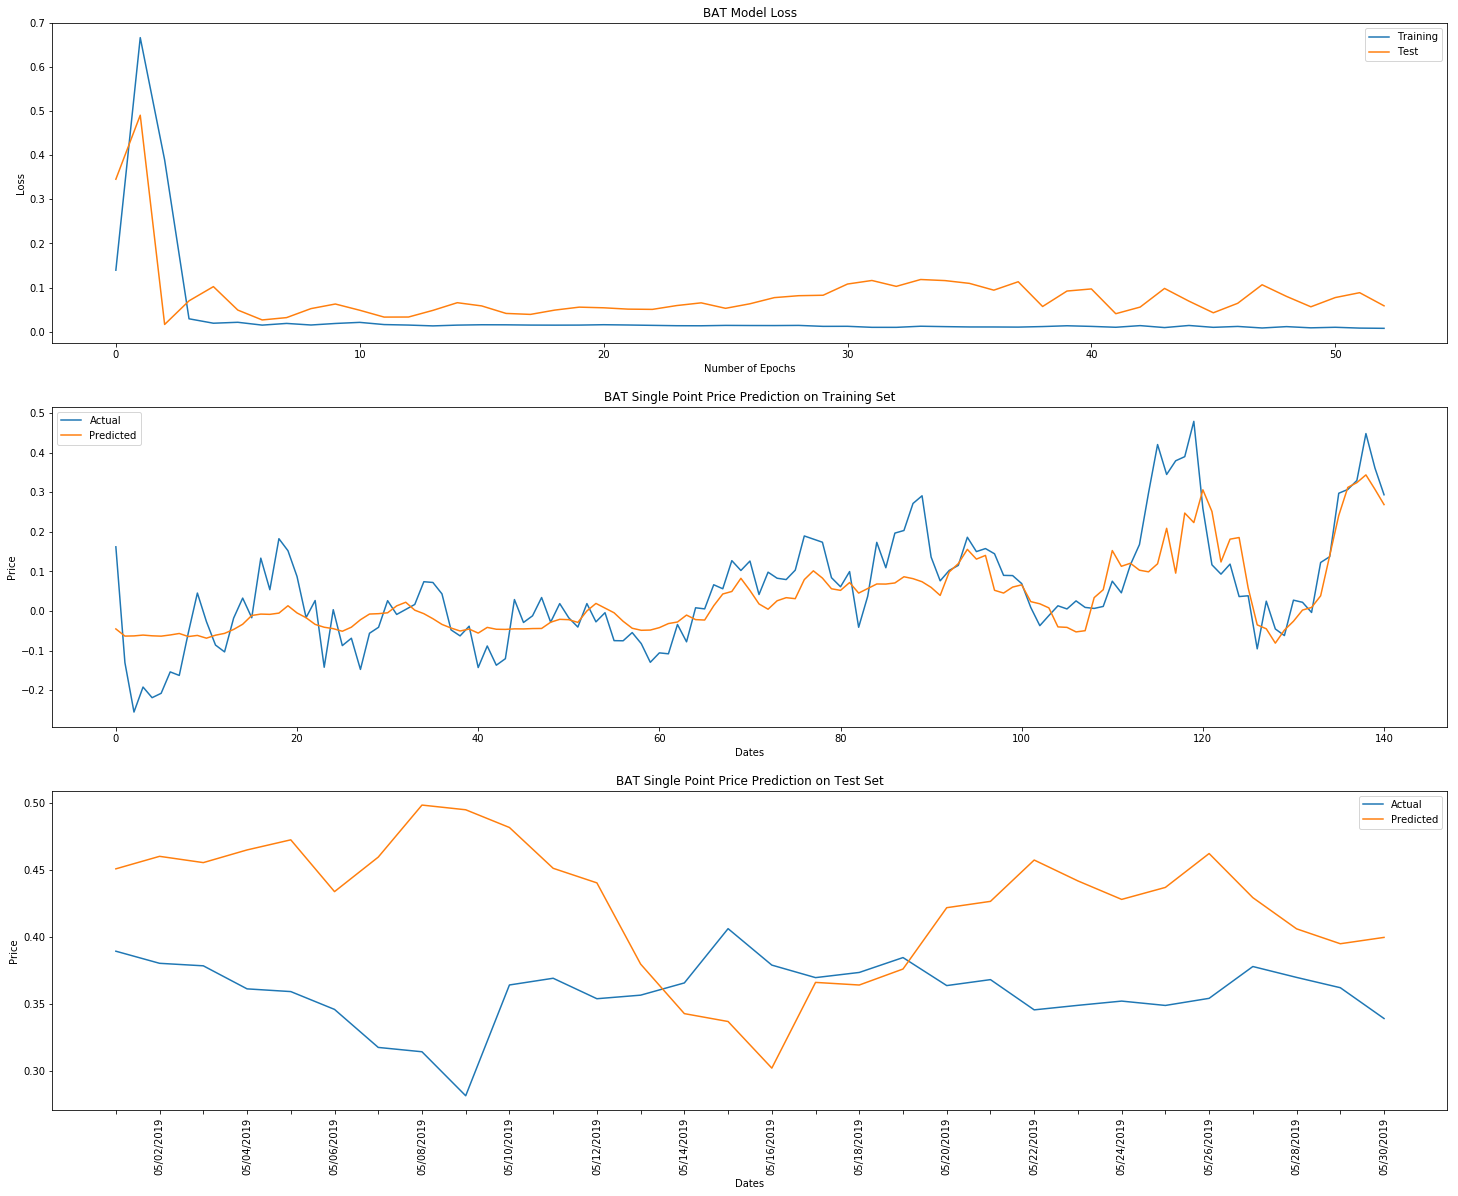

In [337]:
plot_results(bat_history, bat_model, Y_train_bat, coin='BAT')

### Ethereum Opening, Closing prices and BAT volume are strong pricing indicators on the historical dataset. Current metric using LSTM are  loss: 0.0077 - mean_absolute_error: 0.0682 - val_loss: 0.0587 - val_mean_absolute_error: 0.2097,

## Particularly predictable or unpredictable time periods in your historical model,

In [338]:
bat_model.save("RNN_model_bat.h5")